# Probabilistic Graphical Models as a Cybersecurity Tool

# Abstract 

This project is a small subset of tool application from the Georgetown Data Science and Analytics 5650 Computational Social Science course. It investigates how Probabilistic Graphical Models (PGMs) can be used not only for associational reasoning but as a first step toward causal inference in cybersecurity risk modeling. Using Bayesian networks and Markov chains, a simple use case demonstrates a simplified password guessing attack that operates through timing delays or error messages. Through Python simulations and the pgmpy library, we model the operative "attack" and visualization of probability to represent a more general appraoch to probabalistic attack surface management. Treating cyber vulnerabilities probabilistically and dynamically instead of deterministically is a proactive approach to managing cyber threats. 

Ultimately, this work illustrates how tools from computational social science can make cybersecurity systems more transparent and intelligible by modeling risk propagation, adversarial learning, and belief updates in a formal structure. Beyond the academic exercise, the approach could inform a "live" framework for managing cyber threats under uncertainty—bridging simulation, inference, and real-world decision-making.

# Introduction 

Cybersecurity threats are increasingly probabilistic, adaptive, and opaque. Attackers often rely on incomplete information, indirect signals, and iterative strategies: traits that can be captured by Probabilistic Graphical Models (PGMs), which offer a formalism for reasoning under uncertainty. PGMs, particularly Bayesian networks and Markov chains, enable compact representations of conditional dependencies and dynamic state transitions [@koller2009probabilistic].

In this project, we simulate a password guessing attack that leverages system feedback. Inspired by side-channel attack scenarios [@kocher1996timing], we use this toy model to explore how probabilistic inference can reconstruct hidden system states over time. The simulation incorporates both a prior belief over possible characters and a likelihood model informed by empirical or simulated timing data. We then encode the attacker’s belief update process as a Bayesian network using the pgmpy library, allowing for visualization and inference.

The project’s goal is twofold: (1) to model the adversarial learning process using formal tools from computational social science, and (2) to demonstrate how decision-relevant uncertainty evolves as attackers interact with system defenses. This mirrors the approach in Risk Assessment and Decision Analysis with Bayesian Networks [@fenton2018risk], which emphasizes real-world applications of PGMs for decision-making under uncertainty. Unlike traditional deterministic risk models, this probabilistic framework can be closer to a "real-time" risk management response where updated beliefs are modeled using a formal framework. 

By integrating simulation, graphical modeling, and Bayesian reasoning, this work contributes to the study of socio-technical risk systems and supports a reproducible, modular approach to reasoning about adversarial behavior.

# Demonstration

We start with one of the simplest possible cybersecurity tasks, a password hack. Many beginner applications contain login checks similar to this code: 

In [1]:
def insecure_check(user_input):
    secret = "hunter2"
    for i in range(len(user_input)):
        if i >= len(secret) or user_input[i] != secret[i]:
            return False
    return len(user_input) == len(secret)

In this code, if the first character is wrong, it returns immediately. If the first character is right, it moves to the second (etc.). 

This is a constant-time comparison. It is easy to implement insecurely, and easier to break in code that does not implement similar checks properly. Below is a sample script that measures the time it takes to check correct inputs - the timing for the system to check 'incorrect' versus 'correct' inputs is different, by monitoring those time deltas you can confirm that password characters are correct during entry before pressing "enter" to test the password input. 

## Pure Binary Timing Attack 

In [2]:
import time

def test_guess(password_guess):
    start = time.perf_counter()
    insecure_check(password_guess)
    end = time.perf_counter()
    return end - start


By systematically trying all letters for each position and measuring response time, you can build the password one character at a time. This is why secure code uses constant-time comparison functions. 

# Password Guesser 
## Timing Model

We can represent this as a Bayesian Network or a Markov model, where each character guess is a node whose probability of correctness increases with the time it takes to reject the input. The underlying idea is that the longer the check takes, the more characters are likely to be correct. 

In [3]:
# Verify all modules are available
import timing_model
import wordlike_model
import hybrid_model
import timing_plot
import wordlike_plot
import hybrid_plot
import common_words
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

/Users/elizabethkovalchuk/Documents/dev_environments/miniforge3/envs/hack_demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Target password: Secret123


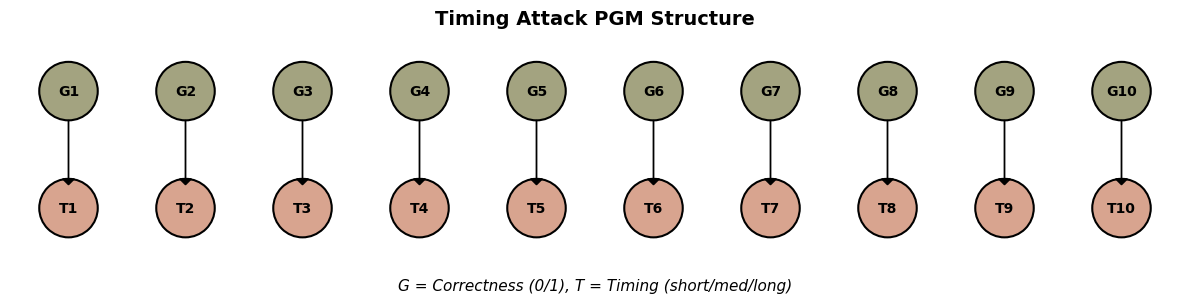

In [4]:
# ============================================================================
# PART 1: TIMING ATTACK
# ============================================================================

# Import timing attack components
from timing_model import (
    build_timing_model,
    collect_timing_data,
    bin_timing_measurements,
    run_timing_inference,
    suggest_binary_guess,
    demo_timing_attack
)
from timing_plot import (
    plot_timing_pgm_structure,
    plot_timing_posteriors,
    plot_timing_operational
)

# Set target password for timing attack
target_password = "Secret123"
print(f"\nTarget password: {target_password}")
# print(f"Password length: {len(target_password)}")

fig = plot_timing_pgm_structure(figsize=(12, 4))
plt.show()

Each node labeled G₁ through G₁₀ represents a latent variable indicating the true bit (0 or 1) at each position in the guessed password. The added annotation (e.g., = 0 (60%)) indicates the most probable value inferred for that variable, based on observed timing feedback.

In [5]:
timings = collect_timing_data(target_password)
timing_classes = bin_timing_measurements(timings)
model = build_timing_model()
posteriors = run_timing_inference(model, timing_classes)
binary_guess = suggest_binary_guess(posteriors)

print(f"Binary prediction: {binary_guess}")
print("Interpretation: '1' = likely correct position, '0' = likely incorrect")

Binary prediction: 0011111110
Interpretation: '1' = likely correct position, '0' = likely incorrect


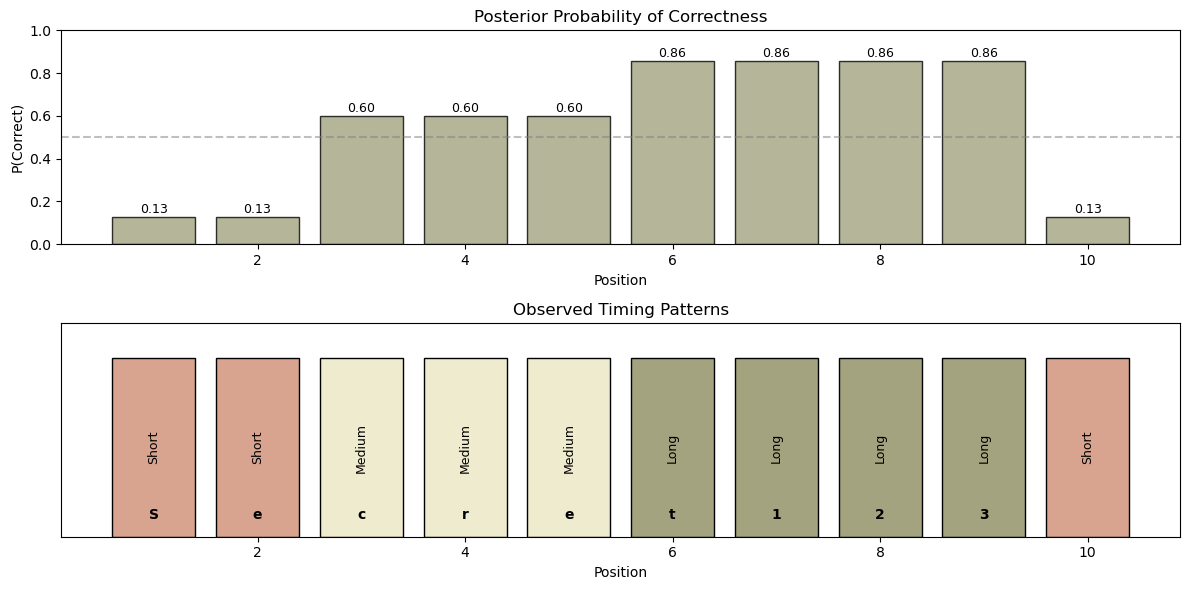


TIMING ATTACK SUMMARY
----------------------------------------
Average P(correct): 0.560
Positions with high confidence (P>0.7): 4


In [6]:
# Show posterior probabilities
fig = plot_timing_posteriors(posteriors, 
                            timing_classes=timing_classes,
                            secret=target_password,
                            figsize=(12, 6))
plt.show()

# Summary of timing attack
print("\nTIMING ATTACK SUMMARY")
print("-" * 40)
correctness_probs = []
for i in range(1, 11):
    if f"G{i}" in posteriors:
        correctness_probs.append(posteriors[f"G{i}"].values[1])
    else:
        correctness_probs.append(0.5)

print(f"Average P(correct): {np.mean(correctness_probs):.3f}")
print(f"Positions with high confidence (P>0.7): {sum(1 for p in correctness_probs if p > 0.7)}")

The percentage shows the model's confidence in that guess — in this example, G₄ = 0 (60%) means the model predicts the third and fourth bits with 60% posterior probability. This probabilistic interpretation is important because it captures the uncertainty in each inference step and can be used to adaptively refine guesses in future attack iterations. 

These results are pretty simple. The probabilities based on this basic code don't really give us a lot of confidence when we examine the suggested entry for the password check, do they? To try and provide something a little more realistic, we'll try another iteration using the PGM models to think about how we might show something more useful. Let's try and update our model per words in the english language to help predict the next character. 

## Character Prediction 

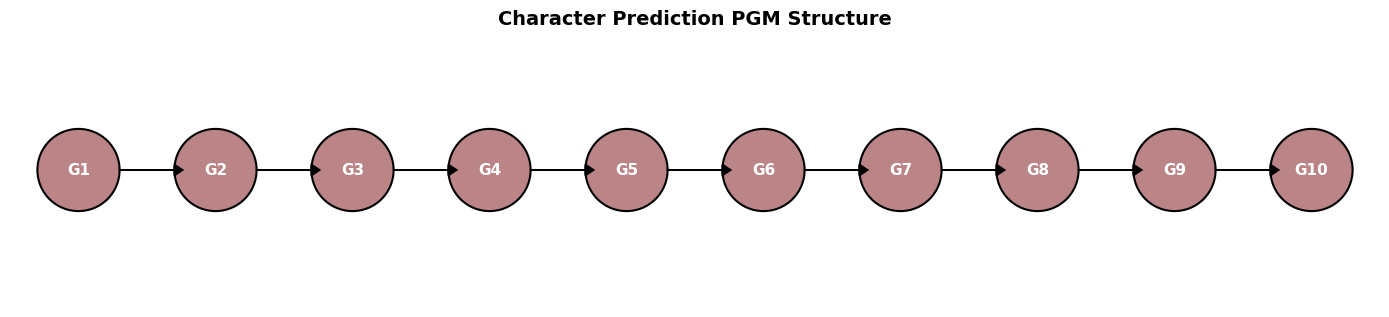

In [7]:
# ============================================================================
# PART 2: CHARACTER PREDICTION (WORDLIKE)
# ============================================================================

from wordlike_model import (
    build_wordlike_model,
    run_wordlike_inference,
    suggest_wordlike_guess,
    get_top_k_predictions,
    CHARSET_INDEX
)
from wordlike_plot import (
    plot_wordlike_pgm_structure,
    plot_wordlike_posteriors,
    plot_wordlike_operational
)
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
target_word = "vegetable"
known_prefix = "veg"

# Show PGM Structure
fig = plot_wordlike_pgm_structure(figsize=(14, 4))
plt.show()

Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt
Final hybrid wordlist: 3899 entries
Wordlike model built with 3899 training words


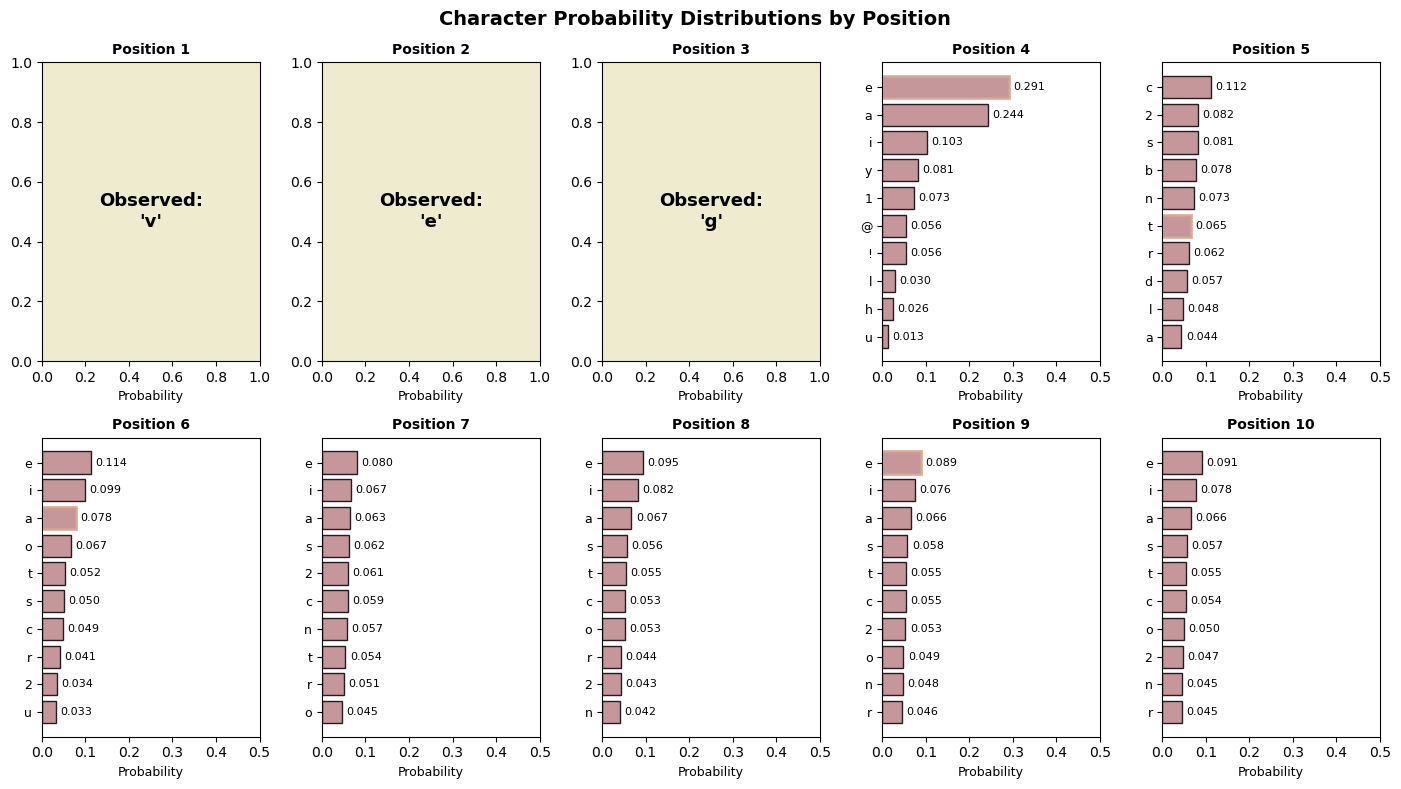

In [8]:
# Build Model 
model_wordlike = build_wordlike_model()

# Run Character Prediction 
observed_chars = {f"G{i+1}": CHARSET_INDEX[char] for i, char in enumerate(known_prefix)}
posteriors_wordlike = run_wordlike_inference(model_wordlike, observed_chars)
guess_wordlike = suggest_wordlike_guess(posteriors_wordlike, observed_chars)
top_predictions = get_top_k_predictions(posteriors_wordlike, k=3)

# Visualization 
fig = plot_wordlike_posteriors(
    posteriors_wordlike,
    observed=observed_chars,
    target=target_word,
    figsize=(14, 8)
)
plt.show()


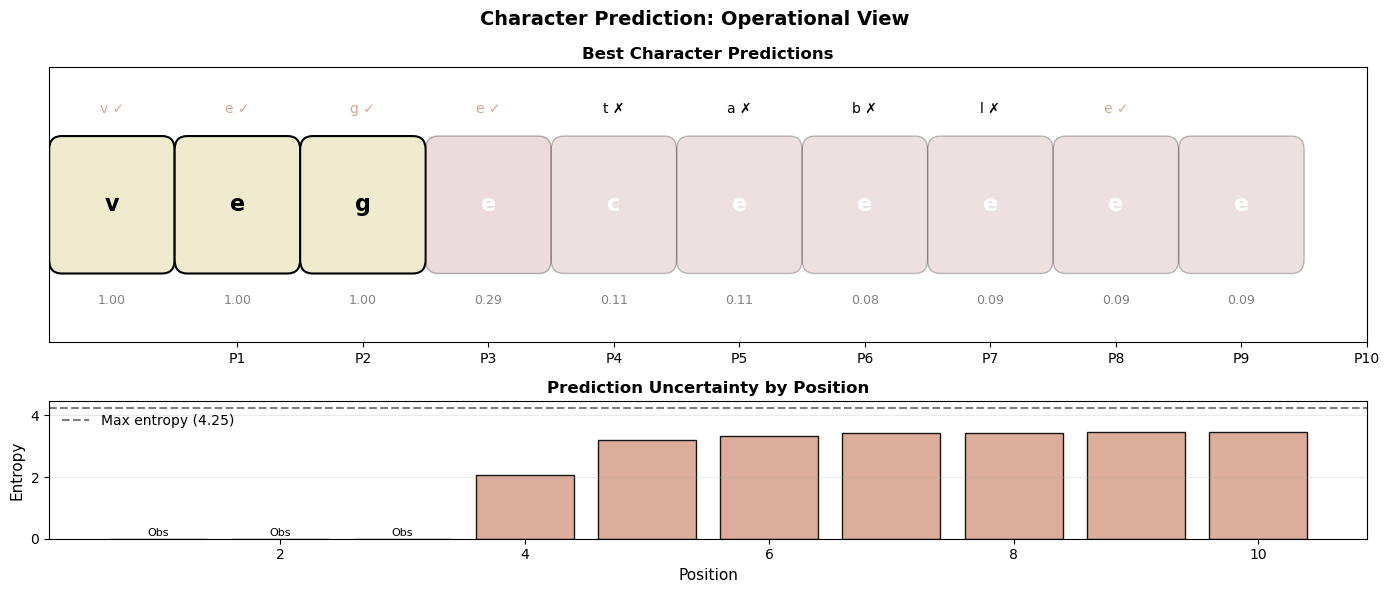

In [9]:
fig = plot_wordlike_operational(
    posteriors_wordlike,
    observed=observed_chars,
    target=target_word,
    figsize=(14, 6)
)
plt.show()

In [10]:
# Summary
print(f"Target password: {target_word}")
print(f"Known prefix: {known_prefix}")
print(f"Predicted password: {guess_wordlike}")

print("\nTop 3 predictions per position:")
for pos in range(len(known_prefix) + 1, min(len(target_word) + 1, 11)):
    if pos in top_predictions:
        preds = top_predictions[pos]
        print(f"Position {pos}: {', '.join([f'{c}({p:.2f})' for c, p in preds])}")

accuracy = sum(
    1 for i in range(len(guess_wordlike))
    if i < len(target_word) and guess_wordlike[i] == target_word[i]
)
print(f"\nCharacter accuracy: {accuracy}/{len(target_word)} = {accuracy/len(target_word):.2%}")

Target password: vegetable
Known prefix: veg
Predicted password: vegeceeeee

Top 3 predictions per position:
Position 4: e(0.29), a(0.24), i(0.10)
Position 5: c(0.11), 2(0.08), s(0.08)
Position 6: e(0.11), i(0.10), a(0.08)
Position 7: e(0.08), i(0.07), a(0.06)
Position 8: e(0.09), i(0.08), a(0.07)
Position 9: e(0.09), i(0.08), a(0.07)

Character accuracy: 5/9 = 55.56%


## Hybrid Model 

Now, to integrate the prior guess probabilities from the word model (wordlike_model) and the likelihood from timing data (timing_model).

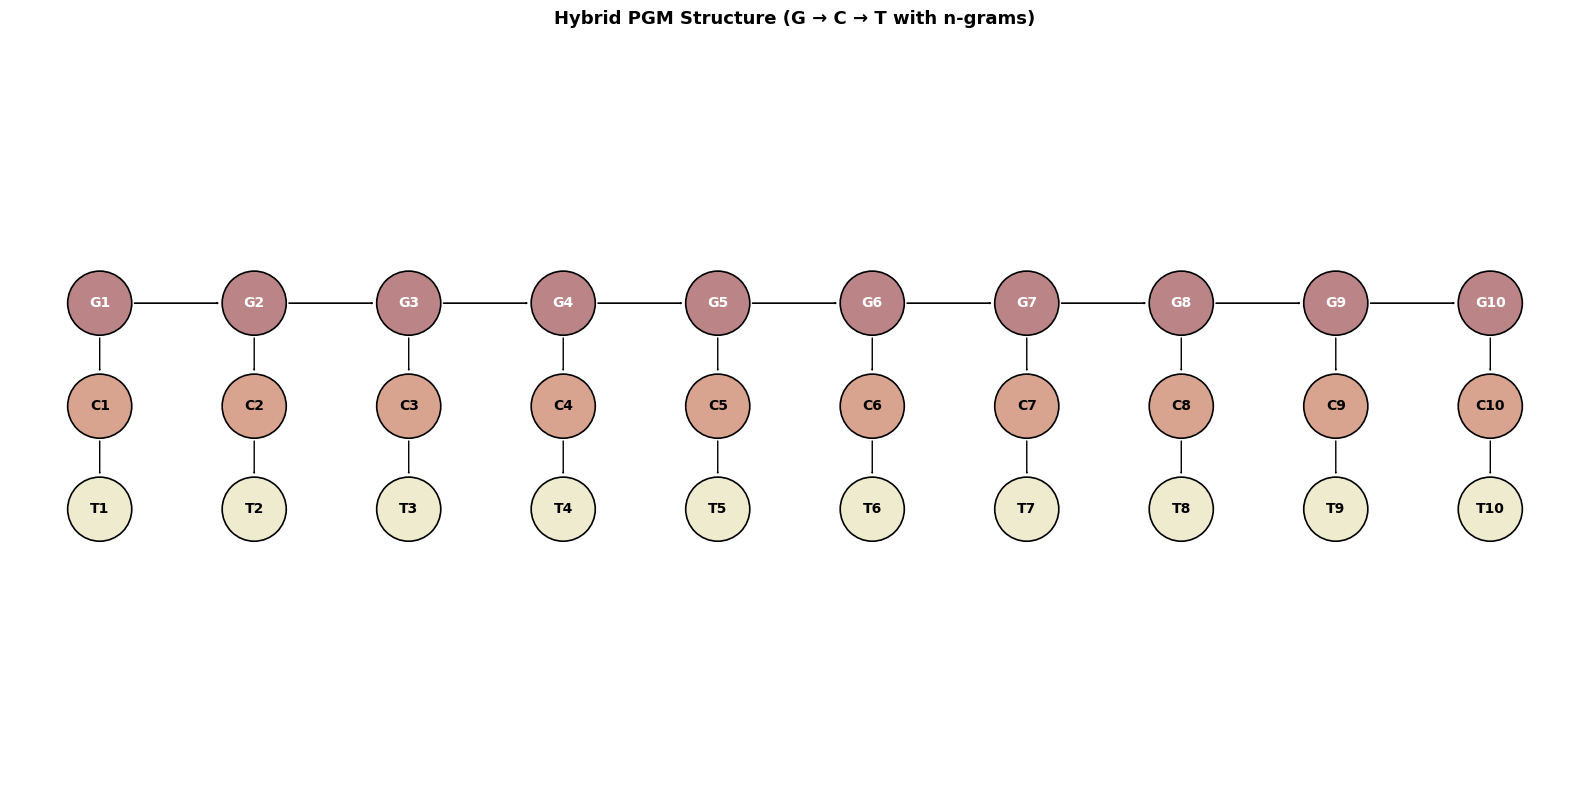

In [11]:
# ============================================================================
# PART 3: HYBRID ATTACK
# ============================================================================

from hybrid_model import (
    build_hybrid_model,
    run_hybrid_inference,
    suggest_hybrid_guess,
    collect_hybrid_timing_data,
    get_hybrid_analysis
)
from hybrid_plot import (
    plot_hybrid_pgm_structure,
    plot_hybrid_posteriors,
    plot_hybrid_operational
)
from timing_model import bin_timing_measurements
from wordlike_model import CHARSET_INDEX
import matplotlib.pyplot as plt
import numpy as np


# Configuration 
hybrid_target = "vegetable"
hybrid_known = "veg"

# Show PGM Structure
fig = plot_hybrid_pgm_structure(figsize=(16, 8))
plt.show()

Loading cached wordlists/rockyou_top2500.txt
Loading cached wordlists/english_words_4_12.txt
Final hybrid wordlist: 3899 entries


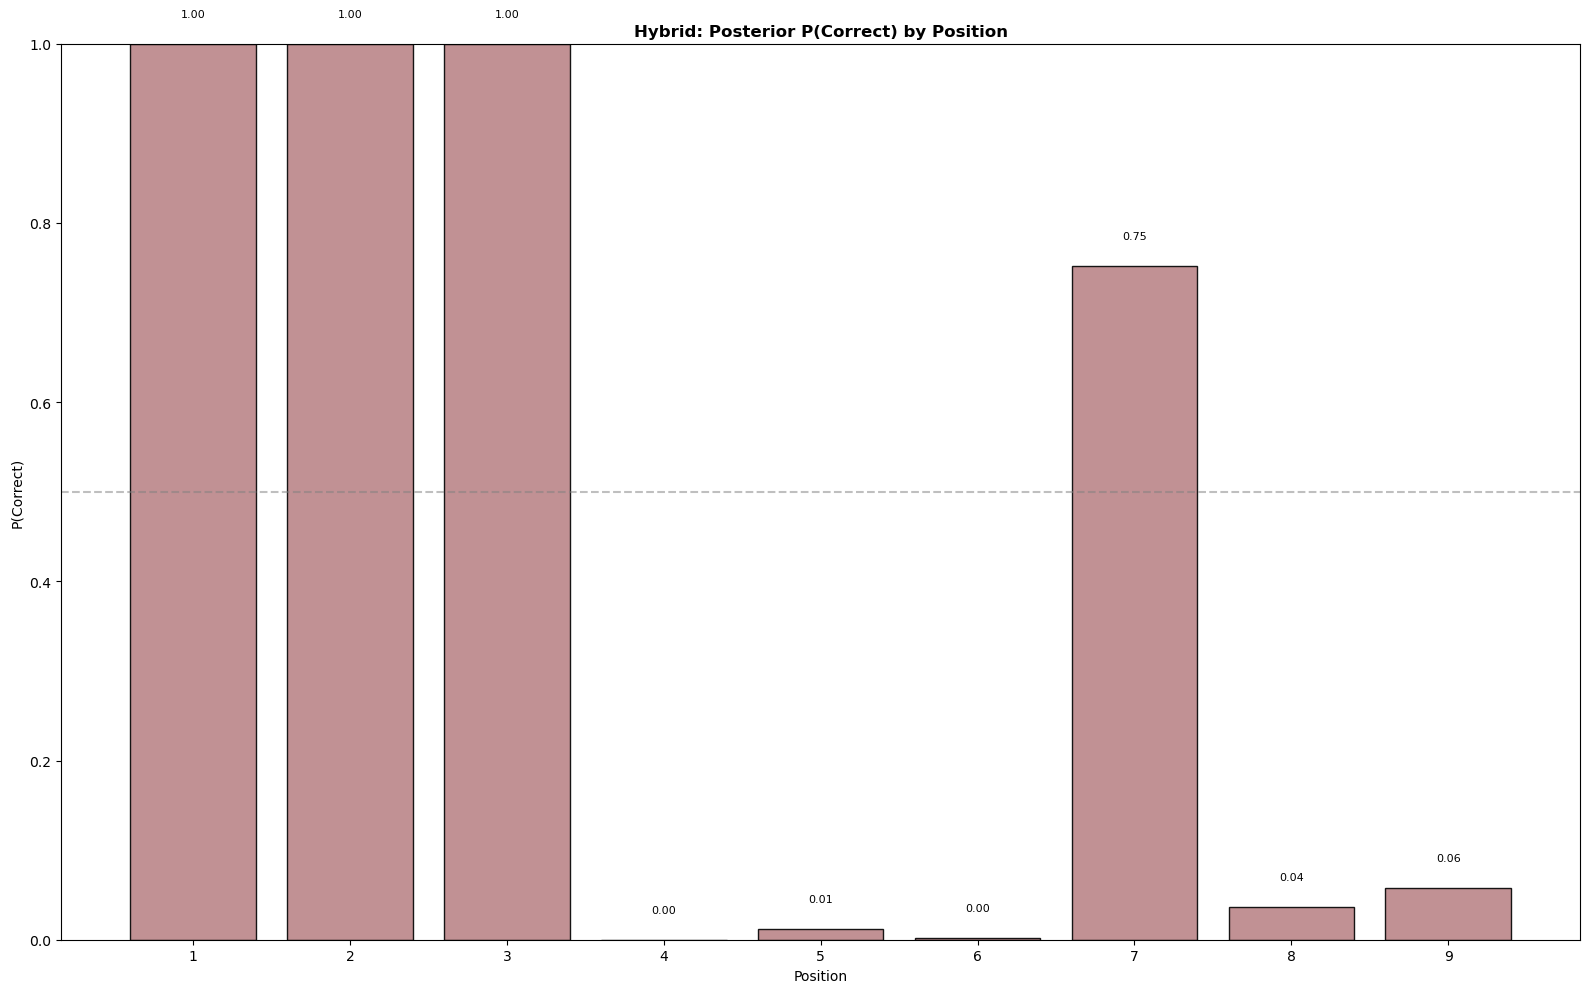

In [12]:
# Build Hybrid Model
model_hybrid = build_hybrid_model(target_password=hybrid_target)

#  Evidence Collection
observed_hybrid = {f"G{i+1}": CHARSET_INDEX[char] for i, char in enumerate(hybrid_known)}
timing_data = collect_hybrid_timing_data(hybrid_known, hybrid_target)
timing_classes_hybrid = bin_timing_measurements(timing_data)

# Inference
posteriors_hybrid = run_hybrid_inference(
    model_hybrid,
    observed_hybrid,
    timing_classes_hybrid
)
guess_hybrid, correctness = suggest_hybrid_guess(posteriors_hybrid, observed_hybrid)
analysis = get_hybrid_analysis(posteriors_hybrid, observed_hybrid)

# Visualizations
fig = plot_hybrid_posteriors(
    posteriors_hybrid,
    observed_chars=observed_hybrid,
    timing_classes=timing_classes_hybrid,
    target=hybrid_target,
    figsize=(16, 10)
)
plt.show()

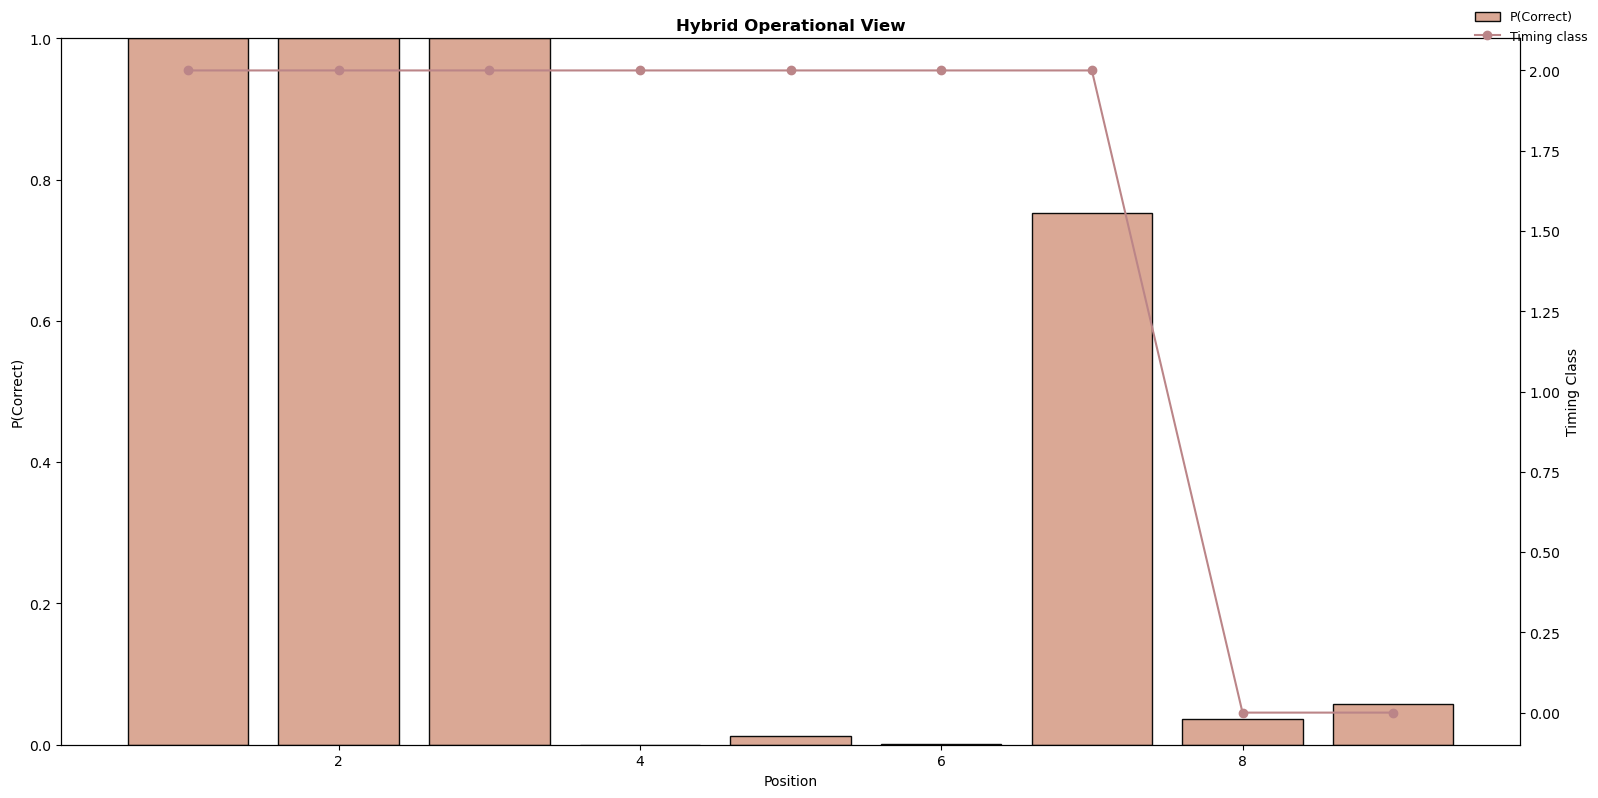

In [13]:
fig = plot_hybrid_operational(
    posteriors_hybrid,
    observed_chars=observed_hybrid,
    timing_classes=timing_classes_hybrid,
    target=hybrid_target,
    figsize=(16, 8)
)
plt.show()

In [14]:
# Summary 
print(f"Target password: {hybrid_target}")
print(f"Known prefix: {hybrid_known}")
print(f"Predicted password: {guess_hybrid}")

accuracy_hybrid = sum(
    1 for i in range(min(len(guess_hybrid), len(hybrid_target)))
    if guess_hybrid[i] == hybrid_target[i]
)
print(f"Hybrid accuracy: {accuracy_hybrid}/{len(hybrid_target)} = {accuracy_hybrid/len(hybrid_target):.2%}")
print(f"Average confidence: {np.mean(analysis['confidence_scores']):.3f}")
print(f"Average P(correct): {np.mean(correctness):.3f}")

Target password: vegetable
Known prefix: veg
Predicted password: vegetabace
Hybrid accuracy: 7/9 = 77.78%
Average confidence: 0.658
Average P(correct): 0.625


# Conclusion

The hybrid model, combining character prediction with timing information, achieved a 77.78% accuracy in recovering the unknown characters of the target password, with an average confidence of 0.658 and an average probability of correctness of 0.625. While not perfect, these results highlight the power of integrating multiple probabilistic signals within a unified Bayesian framework. The approach demonstrates how even partial information—such as a known prefix—can be leveraged to significantly reduce the search space of an attack. This reinforces the core objective of the project: probabilistic reasoning allows adversaries to update beliefs dynamically and adapt their strategies in real time, and the same methods could be inverted to strengthen defensive monitoring, detection, and mitigation in cybersecurity systems.